<a href="https://colab.research.google.com/github/akankshakusf/Project-CNN-Deep-Learning-Malaria-Detection/blob/master/Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer

# Data Preparation

## Data Loading

In [27]:
# Import the Malaria dataset from TensorFlow Datasets (TFDS) and split it into three parts:
# - The first 80% of the data will be used for training.
# - The next 10% (80%-90%) will be used for validation
# - The last 10% (90%-100%) will be used for testing.
# and shuffle files

dataset, dataset_info = tfds.load(
    "malaria", with_info=True,as_supervised=True, shuffle_files=True)


Scenario: lets say you dnt pull the data out from tensorflow instead you are pull it from you .text file. below is the approuch we will take

In [28]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    # Get dataset size (Corrected)
    DATASET_SIZE = tf.data.experimental.cardinality(dataset).numpy()

    # Make train, val, test split
    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))  # Skip train data
    val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
    test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))  # Remaining data as test

    return train_dataset, val_dataset, test_dataset  # Fixed return statement

In [29]:
###### split function logic explaination builder ######

# TRAIN_RATIO=0.6
# VAL_RATIO=0.2
# TEST_RATIO=0.2
# TOTAL=10
# #set range on data for testing logic
# ds=tf.data.Dataset.range(TOTAL)
# #train_sd,val_ds,test_ds=split(ds,TRAIN_RATIO,VAL_RATIO,TEST_RATIO)
# train_ds=ds.take(int(TRAIN_RATIO*TOTAL))
# val_test_ds=ds.skip(int(TRAIN_RATIO*TOTAL)) #not important
# val_ds=val_test_ds.take(int(VAL_RATIO*TOTAL))
# test_ds=val_test_ds.skip(int(VAL_RATIO*TOTAL))

# #print main dataset for review
# print([int(x) for x in ds.as_numpy_iterator()])
# print([int(x) for x in train_ds.as_numpy_iterator()])
# print([int(x) for x in val_test_ds.as_numpy_iterator()])
# print([int(x) for x in val_ds.as_numpy_iterator()])
# print([int(x) for x in test_ds.as_numpy_iterator()])


In [30]:
# Shuffle dataset before splitting
dataset = dataset["train"].shuffle(buffer_size=10000, reshuffle_each_iteration=False)

In [31]:
# Define split ratios
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# Call split function
train_dataset, val_dataset, test_dataset = split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [32]:
# Check dataset sizes
print(f"Training size: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Validation size: {tf.data.experimental.cardinality(val_dataset).numpy()}")
print(f"Test size: {tf.data.experimental.cardinality(test_dataset).numpy()}")

Training size: 22046
Validation size: 2755
Test size: 2757


In [33]:
#check data info
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasit

So, in the data 0 represent parasitic
and 1 represents uneffected

In [34]:
# Print a few values from the validation dataset
for i in val_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(169, 160, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


## Dataset Visualization

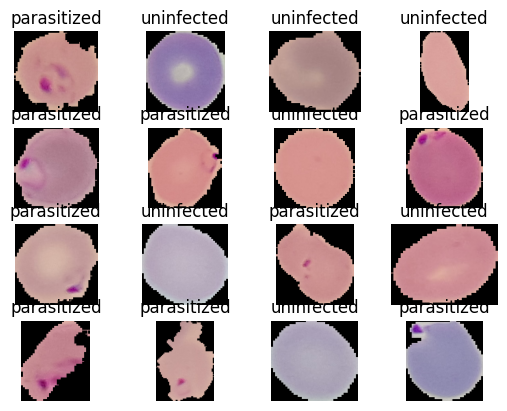

In [35]:
for i, (image, label) in enumerate(train_dataset.take(16)):  #Unpack tuple
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image.numpy())  # Convert Tensor to NumPy array
    plt.title(dataset_info.features['label'].int2str(label.numpy()))  # Convert label to class name
    plt.axis("off")

plt.show()



## Data Preprocessing

### Data Augmentation

- These images are of bigger sizes (255,255,2) etc. But we will have to Normalize them and bring them in the range of 0-1 so Deep model converges or inference faster

In [36]:
#define the image size we want to reduce to
IM_SIZE=224
BATCH_SIZE=32

def resize_rescale(image, label):
    # Resize and rescale the image
    image = tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255.0
    return image, label

# Apply the function to the dataset
train_dataset = train_dataset.map(resize_rescale).shuffle(buffer_size=1000, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(resize_rescale).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(resize_rescale).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [37]:
for image, label in train_dataset.take(1):
    print("Image shape:", image.shape)
    print("Label:", label)

Image shape: (32, 224, 224, 3)
Label: tf.Tensor([0 0 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1], shape=(32,), dtype=int64)


* see that image size is now 224 : of shape shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)
- tf.Tensor(1, meaning its was not infected cell

In [38]:
#check for unique values in transformed train_dataset
np.set_printoptions(suppress=True, precision=6)
np.unique(image)

array([0.      , 0.000007, 0.000007, ..., 0.967079, 0.971744, 0.972794],
      dtype=float32)

* Notice - here i goal is acchieved of having all values in between 0 to 1

# Model Creation and Training: Using LeNet Architecture

- This exact model summary is explained with full walk through in notion https://www.notion.so/CNN-Layering-Neuron-Count-1bc4ba18200f80ffa385ea743e4a30cd

In [39]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

In [40]:
# Instantiate the CNN model
model = tf.keras.Sequential([

    InputLayer(shape=(IM_SIZE, IM_SIZE, 3)),  # Input: IM_SIZE x IM_SIZE RGB image

    # 1st conv layer (extracts basic patterns)
    Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),  # Downsamples feature maps

    # 2nd conv layer (extracts deeper features)
    Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),  # Downsampling again

    Flatten(),  # Converts 2D feature maps into 1D array

    Dense(100, activation="relu"),  # Fully connected layer
    BatchNormalization(),
    Dense(10, activation="relu"),   # Further processing
    BatchNormalization(),
    Dense(1, activation="sigmoid"),     # Output layer (binary classification)

])

# Print model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

In [42]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.01),  # Optimizer: Adam with learning rate 0.01
    loss=BinaryCrossentropy(),  # Loss function: Binary Crossentropy for binary classification
    metrics=['accuracy'],  # Metrics: Binary Accuracy

)



In [43]:
## Create an instance of EarlyStoppping Callback
from tensorflow.keras.callbacks import EarlyStopping
earlystopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
earlystopping

In [45]:
#fit the model
history =model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    verbose=True,
    callbacks=[earlystopping]
)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 55s 71ms/step - accuracy: 0.6475 - loss: 0.6163 - val_accuracy: 0.8105 - val_loss: 0.6364
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 50s 65ms/step - accuracy: 0.9078 - loss: 0.2506 - val_accuracy: 0.9212 - val_loss: 0.2279
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 44s 57ms/step - accuracy: 0.9341 - loss: 0.2046 - val_accuracy: 0.7702 - val_loss: 0.4583
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 53s 68ms/step - accuracy: 0.9421 - loss: 0.1795 - val_accuracy: 0.9477 - val_loss: 0.1521
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 53s 69ms/step - accuracy: 0.9462 - loss: 0.1640 - val_accuracy: 0.9256 - val_loss: 0.1964
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 79s 64ms/step - accuracy: 0.9334 - loss: 0.1999 - val_accuracy: 0.7760 - val_loss: 0.4127
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 84s 66ms/step - accuracy: 0.9505 - loss: 0.1530 - val_accuracy: 0.9495 - val_loss: 0.6952
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 46s 57ms/step - accuracy: 0.9523 - loss: 0.1460 - 

##Visualizations

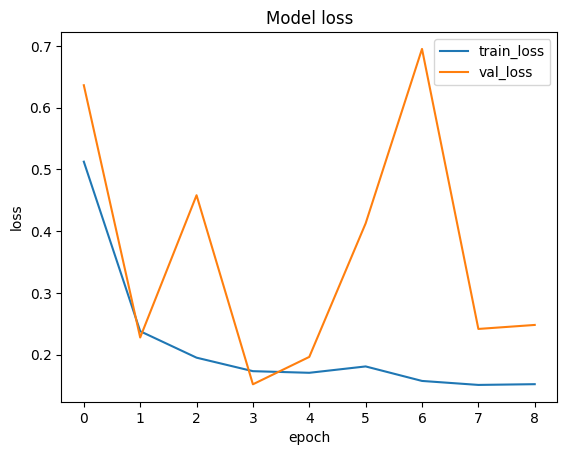

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

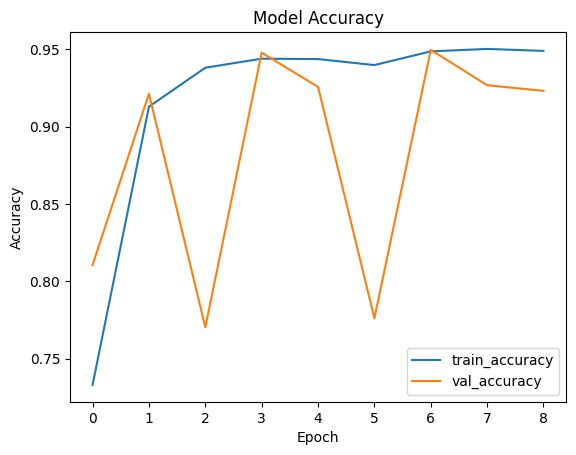

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()